<a href="https://colab.research.google.com/github/Raanank10/Instagram-s-influencers/blob/main/Instagram_influencers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instagram_influencers**

# Global Parameters

In [111]:
fname = 'ai_posts_analysis_data.xlsx'

# Get the Data

In [112]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd
import missingno as msno

# SK Learn
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score , confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report # elad 20210708
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

# Trees Visualization
import pydot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

# Misc
import warnings
from sys import modules
from time import time
from platform import python_version

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# IPython
from IPython.display import Image, display

# Confuguration
warnings.filterwarnings('ignore')
%matplotlib inline

In [113]:
df = pd.read_excel(fname, index_col=0)  
df.head()

,USERID,USERNAME,FULLNAME,FOLLOWER,POST ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE LABELS,CAPTION INTEREST,ACCESSIBILITY CAPTION INTEREST,IMAGE LABEL INTEREST,IMAGE URL,COMMENT DISABLED,IS VIDEO,HAS AUDIO,VIDEO URL,VIDEO VIEW COUNT
1,,,,,,,,,,,,,,,,,,,,,,,,,,
1918,36193140327,elastici_e_passamaneria,Elastici e Passamaneria,1052,2530600951335029174,CMegChUlwm2,23,0,2.19,https://www.instagram.com/p/CMegChUlwm2,"Photo by Elastici e Passamaneria on March 16, ...",FFP2 MADE IN ITALY????????#ffp2mask#italiansty...,NaN,NaN,NaN,1615891163,"Clothing, Apparel, Text, Money, Collage, Adver...",education,movies,business,https://instagram.fdok2-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN
1919,8210198494,pamela.latorre.73,Pamela La Torre,309,2595285287724490476,CQETjgBnZ7s,55,23,25.24,https://www.instagram.com/p/CQETjgBnZ7s,"Photo by Pamela La Torre on June 13, 2021. May...",Prima comunione Giorgio,Santissimo Crocifisso,"Taranto, Italy",NaN,1623602137,"Person, Human, Photographer, Photography, Phot...",news,arts_entertainment,style_fashion,https://instagram.fhel3-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN
1920,36838177086,ilaria._004,????????????????,649,2356209223949454778,CCy784yAY26,138,2,21.57,https://www.instagram.com/p/CCy784yAY26,"Photo by ???????????????? on July 18, 2020. Ma...",mirame????,NaN,NaN,NaN,1595102049,"Clothing, Apparel, Person, Human, Female, Swim...",education,arts_entertainment,style_fashion,https://instagram.fgua5-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN
1921,33286901341,wellbishstore,Wellbish Store,188,2462740031272344745,CItaQKiH1yp,6,0,3.19,https://www.instagram.com/p/CItaQKiH1yp,"Photo by Wellbish Store on December 12, 2020. ...",How sweet is your Heart? ❤️????\n.\n.\n???? Fo...,NaN,NaN,NaN,1607801511,"Pendant, Accessories, Accessory, Goggles",style_fashion,arts_entertainment,style_fashion,https://instagram.fhyd2-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN
1922,5633363536,amineblc,Mohamed Amine,1103,2127311663854320191,B2Fuq_ylPo_,46,4,4.53,https://www.instagram.com/p/B2Fuq_ylPo_,Photo by Mohamed Amine in Mawazine.,NaN,Mawazine,"Ksar Hellal, Tunisia",Tunisia,1567815333,"Clothing, Apparel, Person, Human, Sunglasses, ...",NaN,news,style_fashion,https://instagram.fjdf6-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4792 entries, 1918 to 6709
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          4792 non-null   int64  
 1   USERNAME                        4792 non-null   object 
 2   FULLNAME                        4666 non-null   object 
 3   FOLLOWER                        4792 non-null   int64  
 4   POST ID                         4792 non-null   int64  
 5   SHORTCODE                       4792 non-null   object 
 6   LIKES                           4792 non-null   int64  
 7   COMMENTS                        4792 non-null   int64  
 8   ENGAGEMENT                      4792 non-null   float64
 9   URL                             4792 non-null   object 
 10  ACCESSIBILITY CAPTION           3943 non-null   object 
 11  CAPTION                         4310 non-null   object 
 12  LOCATION                       

# EDA

Column names: Replace white spaces with underscore 

In [115]:
df.columns = df.columns.str.replace(' ', '_')

Check for each column how many unique is there (lenght of the dataset 4792, len(df)) 

In [116]:
df.apply(lambda col: len(col.unique())).sort_values(ascending=False)

POST_ID                           4792
SHORTCODE                         4792
IMAGE_URL                         4792
URL                               4792
TIME                              4791
IMAGE_LABELS                      4666
CAPTION                           4216
ACCESSIBILITY_CAPTION             3658
ENGAGEMENT                        1415
VIDEO_URL                          809
LIKES                              588
LOCATION                           533
VIDEO_VIEW_COUNT                   472
USERNAME                           447
USERID                             447
FULLNAME                           432
FOLLOWER                           418
CITY                               328
COMMENTS                           138
COUNTRY                             44
CAPTION_INTEREST                    36
IMAGE_LABEL_INTEREST                35
ACCESSIBILITY_CAPTION_INTEREST      27
COMMENT_DISABLED                     2
IS_VIDEO                             2
HAS_AUDIO                

## Handle NaN valus

How Many NaN values are ther in the datast?

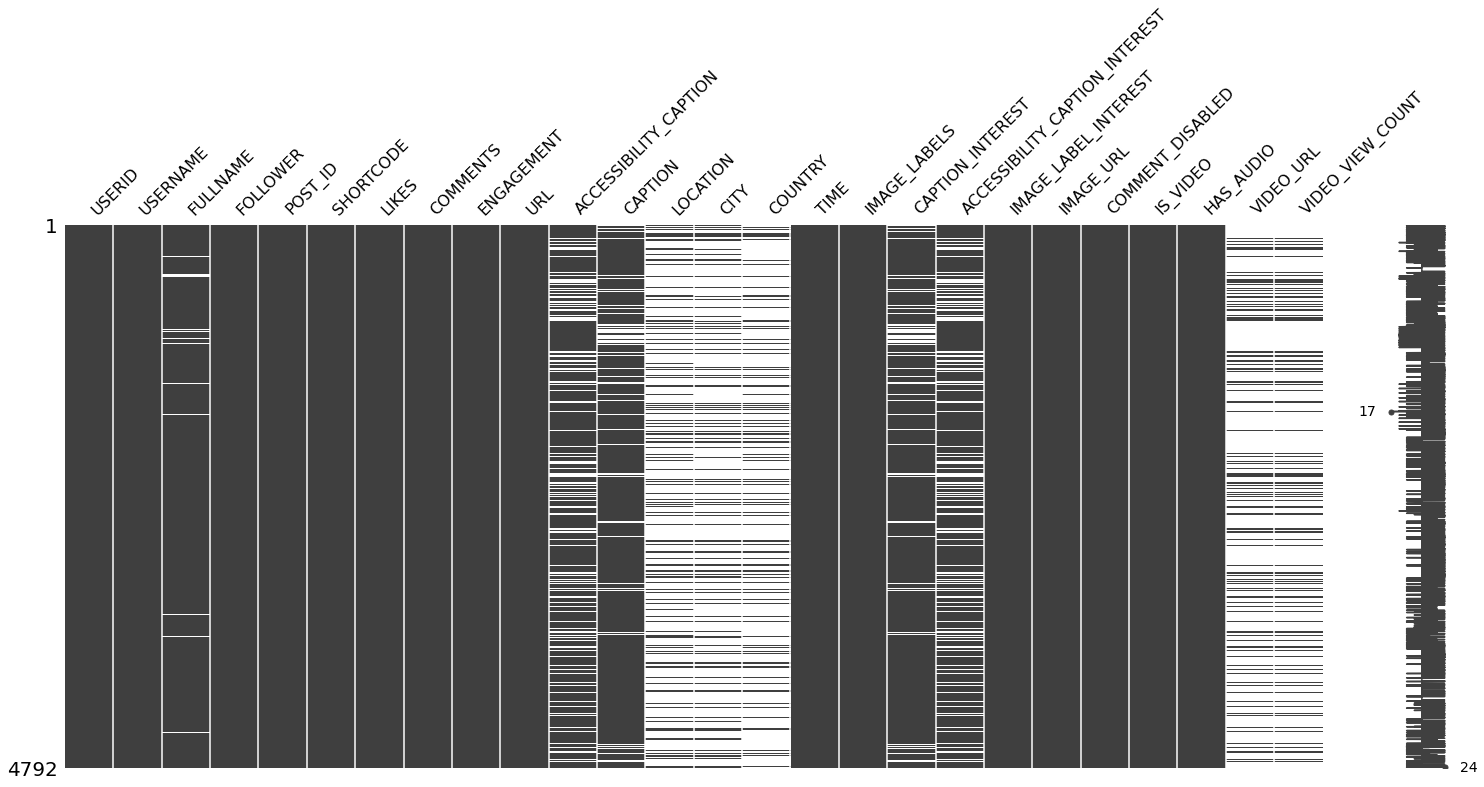

In [117]:
msno.matrix(df)

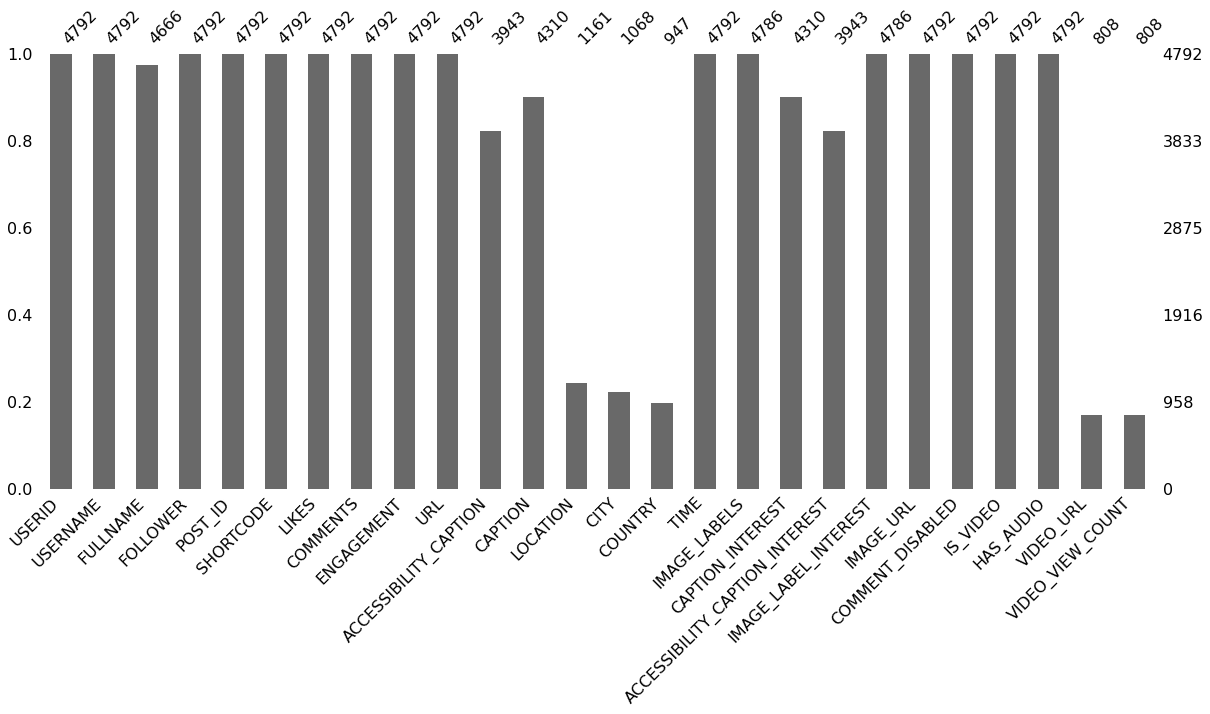

In [118]:
msno.bar(df, figsize=(20, 8))

In [119]:
df['YEAR'] = pd.DatetimeIndex(df['TIME']).year
df['MONTH'] = pd.DatetimeIndex(df['TIME']).month
df['DAY'] = pd.DatetimeIndex(df['TIME']).day
df['DAYOFWEEK'] = pd.DatetimeIndex(df['TIME']).dayofweek
df['HOUR'] = pd.DatetimeIndex(df['TIME']).hour

Remove column that all values are unique:

In [120]:
for col in df.columns:
    if len(df[col].unique()) == len(df):
        print(col)
        #df.drop(col,inplace=True,axis=1)

POST_ID
SHORTCODE
URL
IMAGE_URL


In [121]:
df

,USERID,USERNAME,FULLNAME,FOLLOWER,POST_ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY_CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE_LABELS,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,IMAGE_LABEL_INTEREST,IMAGE_URL,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,VIDEO_URL,VIDEO_VIEW_COUNT,YEAR,MONTH,DAY,DAYOFWEEK,HOUR
1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1918,36193140327,elastici_e_passamaneria,Elastici e Passamaneria,1052,2530600951335029174,CMegChUlwm2,23,0,2.19,https://www.instagram.com/p/CMegChUlwm2,"Photo by Elastici e Passamaneria on March 16, ...",FFP2 MADE IN ITALY????????#ffp2mask#italiansty...,NaN,NaN,NaN,1615891163,"Clothing, Apparel, Text, Money, Collage, Adver...",education,movies,business,https://instagram.fdok2-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN,1970,1,1,3,0
1919,8210198494,pamela.latorre.73,Pamela La Torre,309,2595285287724490476,CQETjgBnZ7s,55,23,25.24,https://www.instagram.com/p/CQETjgBnZ7s,"Photo by Pamela La Torre on June 13, 2021. May...",Prima comunione Giorgio,Santissimo Crocifisso,"Taranto, Italy",NaN,1623602137,"Person, Human, Photographer, Photography, Phot...",news,arts_entertainment,style_fashion,https://instagram.fhel3-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN,1970,1,1,3,0
1920,36838177086,ilaria._004,????????????????,649,2356209223949454778,CCy784yAY26,138,2,21.57,https://www.instagram.com/p/CCy784yAY26,"Photo by ???????????????? on July 18, 2020. Ma...",mirame????,NaN,NaN,NaN,1595102049,"Clothing, Apparel, Person, Human, Female, Swim...",education,arts_entertainment,style_fashion,https://instagram.fgua5-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN,1970,1,1,3,0
1921,33286901341,wellbishstore,Wellbish Store,188,2462740031272344745,CItaQKiH1yp,6,0,3.19,https://www.instagram.com/p/CItaQKiH1yp,"Photo by Wellbish Store on December 12, 2020. ...",How sweet is your Heart? ❤️????\n.\n.\n???? Fo...,NaN,NaN,NaN,1607801511,"Pendant, Accessories, Accessory, Goggles",style_fashion,arts_entertainment,style_fashion,https://instagram.fhyd2-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN,1970,1,1,3,0
1922,5633363536,amineblc,Mohamed Amine,1103,2127311663854320191,B2Fuq_ylPo_,46,4,4.53,https://www.instagram.com/p/B2Fuq_ylPo_,Photo by Mohamed Amine in Mawazine.,NaN,Mawazine,"Ksar Hellal, Tunisia",Tunisia,1567815333,"Clothing, Apparel, Person, Human, Sunglasses, ...",NaN,news,style_fashion,https://instagram.fjdf6-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN,1970,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6705,21497287,clinton_buckley,Clinton Buckley,442,2492770169244451884,CKYGUL8gYQs,27,4,7.01,https://www.instagram.com/p/CKYGUL8gYQs,Photo by Clinton Buckley in PIXAR Putt. May be...,"#pixarputt with the kid today, thanks to @rebe...",PIXAR Putt,"Brisbane, Queensland, Australia",NaN,1611381382,"Hat, Clothing, Apparel, Person, Human, Sunglas...",hobbies_interests,music,style_fashion,https://instagram.fcgk9-2.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN,1970,1,1,3,0
6706,2058525803,elvisonradio,Elvis The Main Ace,3576,2581199666677175865,CPSQ2vKplY5,148,29,4.95,https://www.instagram.com/p/CPSQ2vKplY5,"Photo by Elvis The Main Ace on May 24, 2021. M...","Happy birthday son , keep shining and may your...",NaN,NaN,NaN,1621923000,"Clothing, Apparel, Boy, Person, Human, T-Shirt...",parenting,movies,style_fashion,https://scontent-iev1-1.cdninstagram.com/v/t51...,no,no,no,NaN,NaN,1970,1,1,3,0
6707,2058525803,elvisonradio,Elvis The Main Ace,3576,2564666284317341928,COXhmW8J_jo,176,33,5.84,https://www.instagram.com/p/COXhmW8J_jo,"Photo by Elvis The Main Ace on May 02, 2021. M...",It shall be very clear,NaN,NaN,NaN,1619952067,"Cushion, Face, Person, Human, Glasses, Accesso...",desserts_baking,movies,style_fashion,https://scontent-iev1-1.cdninstagram.com/v/t51...,no,no,no,NaN,NaN,1970,1,1,3,0


In [122]:
df.IMAGE_URL.head()
# SHORTCODE
# URL
# IMAGE_URL

1
1918    https://instagram.fdok2-1.fna.fbcdn.net/v/t51....
1919    https://instagram.fhel3-1.fna.fbcdn.net/v/t51....
1920    https://instagram.fgua5-1.fna.fbcdn.net/v/t51....
1921    https://instagram.fhyd2-1.fna.fbcdn.net/v/t51....
1922    https://instagram.fjdf6-1.fna.fbcdn.net/v/t51....
Name: IMAGE_URL, dtype: object

In [123]:
df.drop('POST_ID',inplace=True,axis=1)

In [124]:
df.drop('SHORTCODE',inplace=True,axis=1)

In [125]:
# df.drop('URL',inplace=True,axis=1)

In [126]:
df.drop('IMAGE_URL',inplace=True,axis=1)

Convert columns type to characters :

In [127]:
df['COMMENT_DISABLED'].value_counts()

no     4785
yes       7
Name: COMMENT_DISABLED, dtype: int64

In [128]:
df['COMMENT_DISABLED'] = df['COMMENT_DISABLED'].map(dict(yes=1, no=0))

In [129]:
df['IS_VIDEO'] = df['IS_VIDEO'].map(dict(yes=1, no=0))

In [130]:
df['HAS_AUDIO'] = df['HAS_AUDIO'].map(dict(yes=1, no=0))

In [131]:
df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].value_counts()

COMMENT_DISABLED  IS_VIDEO  HAS_AUDIO
0                 0         0            3981
                  1         1             722
                            0              82
1                 1         1               4
                  0         0               3
dtype: int64

In [132]:
pd.unique(df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].values.ravel('K'))

array([0, 1])

Conert unix time to separate Date and Time columns

## Data Cleaning

## Replacing Charecters  with Number

## Feature Engneering

# Split the Data

# Mechine Learning  Model

## Appling First1 Model 

## Validating the Model 

## Scoring 